In [1]:
import os
from pathlib import Path
import requests
from tqdm import tqdm
from typing import Union, List

import math
import torch
import numpy as np
import audiotools
import dasp_pytorch
import auraloss
# import laion_clap
import pandas as pd
from audiotools import AudioSignal

from transformers import BertForMaskedLM

from scipy import signal
import matplotlib.pyplot as plt

import helper

# dir(helper)

In [2]:
NOTEBOOKS_DIR = Path(os.path.abspath(''))
PROJECT_DIR = NOTEBOOKS_DIR.parent
ASSETS_DIR = PROJECT_DIR / "assets"
PRETRAINED_DIR = PROJECT_DIR / "pretrained"
DATA_DIR = PROJECT_DIR / "data"
RUNS_DIR = PROJECT_DIR / "runs"
EXPERIMENTS_DIR = PROJECT_DIR / "experiments"


AUDEALIZE_COMP_DIR = EXPERIMENTS_DIR / "audealize_comp"
AUDEALIZE_GND_TRUTH_DIR = Path(AUDEALIZE_COMP_DIR / "audealize_version")

print(ASSETS_DIR)

/home/annie/research/text2fx/assets


### Setting Up Audealize Ground Truth Files

##### Loading in Audealize API / word <> EQ settings

In [3]:
# Load JSON data Audealize API word <> EQ gain values
file_path = '/home/annie/research/text2fx/notebooks/audealize_data/eqdescriptors.json'
top10_eq = ["warm", "cold", "soft", "loud", "happy", "bright", "soothing", "harsh", "heavy", "cool"]
settings_dict = helper.get_settings_for_words(file_path, top10_eq)
# print(settings_dict['cool'])

# Zipping (frequency bands, gain vals) in dictionary
freq_bands = [20, 50, 83, 120, 161, 208, 259, 318, 383, 455, 537, 628, 729, 843, 971, 
              1114, 1273, 1452, 1652, 1875, 2126, 2406, 2719, 3070, 3462, 3901, 
              4392, 4941, 5556, 6244, 7014, 7875, 8839, 9917, 11124, 12474, 13984, 
              15675, 17566, 19682]

converted_settings_dict = helper.convert_to_freq_gain_tuples(settings_dict, freq_bands)
# print(converted_settings_dict['cold'])

# Converting all parameters into tensors
tensor_settings = helper.convert_to_tensors(converted_settings_dict)
# print(tensor_settings['cold'])

In [4]:
# Loading audealize ground truth files
all_audealize_samples = helper.load_and_find_path_with_keyword(ASSETS_DIR, ["audealize"], returnSingle=False)
# all_audealize_samples = helper.load_and_find_path_with_keyword(ASSETS_DIR, ["audealize", "piano"], returnSingle=False)

print(all_audealize_samples)

[PosixPath('/home/annie/research/text2fx/assets/audealize_examples/drums.wav'), PosixPath('/home/annie/research/text2fx/assets/audealize_examples/guitar.wav'), PosixPath('/home/annie/research/text2fx/assets/audealize_examples/piano.wav')]


In [5]:
### TESTING NORMALIZATIONG


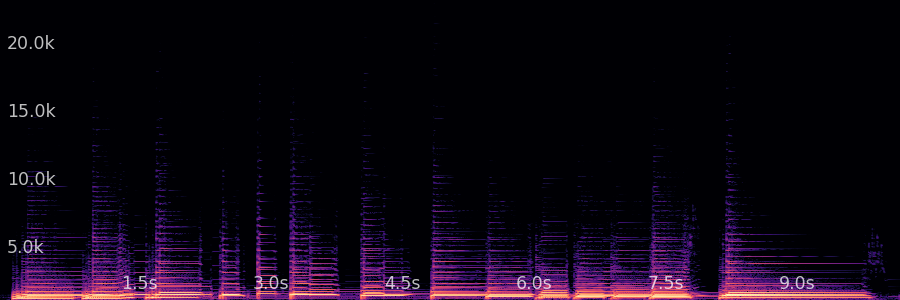
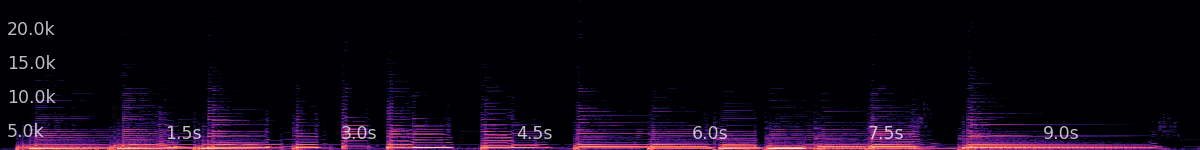

duration: 10.243 seconds
batch_size: 1
path: /tmp/tmptdp_bdm8.wav
sample_rate: 44100
num_channels: 2
audio_data.shape: torch.Size([1, 2, 451714])
stft_params: STFTParams(window_length=2048, hop_length=512, window_type='hann', match_stride=False, padding_type='reflect')
device: cpu



In [6]:
input_raw = helper.load_and_find_path_with_keyword(ASSETS_DIR, ["guitar"], returnSingle=True) #searches for file
# AudioSignal(input_raw).ensure_max_of_audio().widget()
filter_out = helper.dasp_apply_EQ_file(input_raw, tensor_settings['warm'])
filter_out.widget()
print(filter_out)

##### Generating Audealize Gnd Truth Examples, uncomment to do

In [7]:
# # Original Input
# audio_type = "drums"

# #loading clean file
# input_raw= helper.load_and_find_path_with_keyword(ASSETS_DIR, [f"{audio_type}"], returnSingle=True) #searches for file

# # generating output files
# for word, freq_gains in tensor_settings.items():
#     filter_out= helper.dasp_apply_EQ_file(input_raw, freq_gains)
#     print(f'saving audealize -> {word}')

#     EXPORT_EX_DIR = Path(AUDEALIZE_GND_TRUTH_DIR / f"{audio_type}")
#     EXPORT_EX_DIR.mkdir(exist_ok=True)

#     filter_out.write(Path(EXPORT_EX_DIR, f"audealize_{word}.wav"))

###### checking recorded audealize api file with dasp generated audealize files

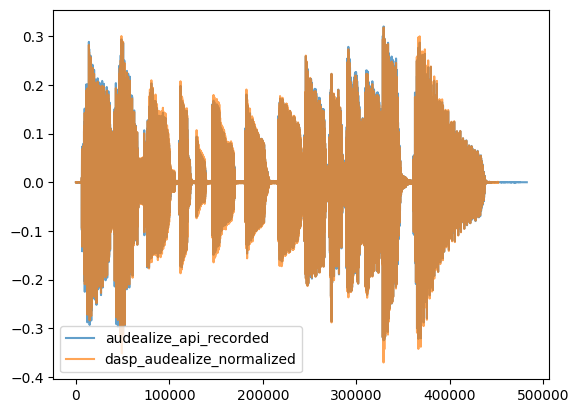

STFT b/w Audealize Gnd Truth and Normalized dasp: 0.48547378182411194
SNR b/w Audealize Gnd Truth and Normalized dasp: -3.706256866455078


In [8]:
s1 = AudioSignal("/home/annie/research/text2fx/experiments/audealize_comp/audealize-gnd-truth.wav")
s3 = AudioSignal("/home/annie/research/text2fx/experiments/audealize_comp/audealize_version/guitar/audealize_warm.wav")
# print(s1, s2, s3)

#preprocessing, setting to mono -> resamples to standard fs --> normalizing
s1 = s1.to_mono().resample(44100).normalize(-24)
s3 = s3.to_mono().resample(44100).normalize(-24)

s1 = s1[..., 7500:]

plt.plot(s1.audio_data.flatten().cpu(), alpha=0.7, label="audealize_api_recorded")
plt.plot(s3.audio_data.flatten().cpu(), alpha=0.7, label="dasp_audealize_normalized")

plt.legend()
plt.show()

#cropping to same length
s1 = s1[..., :min(s1.signal_length, s3.signal_length)]
s3 = s3[..., :min(s1.signal_length, s3.signal_length)]

# Audio Loss
mrstft = auraloss.freq.MultiResolutionSTFTLoss()
print(f'STFT b/w Audealize Gnd Truth and Normalized dasp: {mrstft(s1.samples,s3.samples)}')

snr = auraloss.time.SNRLoss()
print(f'SNR b/w Audealize Gnd Truth and Normalized dasp: {snr(s1.samples,s3.samples)}')

### Comparing Audealize Files with Other Embeddings

### Audealize vs MS CLAP: 
- FX: Just EQ
- Words: Top 10 Frequent EQ words (warm 64, cold 34, soft 29, loud 26, happy 22, bright 19, soothing 17, harsh 16, heavy 15, cool 14)



##### Audio Type: Guitar Riff

In [9]:
keyword = 'guitar'
# Loading Ground Truth Paths
audealize_out_ALL = helper.load_and_find_path_with_keyword(AUDEALIZE_GND_TRUTH_DIR, [f'{keyword}'], returnSingle=False)
print(len(audealize_out_ALL)) #checking length, should be number of words aka 10
# for path in audealize_out_ALL:
#     print(path)

# Loading all MS CLAP output files
MS_CLAP_OUTPUTS = AUDEALIZE_COMP_DIR / "ms_clap" 
msclap_out_ALL = helper.load_and_find_path_with_keyword(MS_CLAP_OUTPUTS, [f'{keyword}', "final"])
print(len(msclap_out_ALL))  #checking length, should be number of words aka 10
# for path in msclap_out_ALL:
#     print(path)

10
10


In [10]:
# Testing for a single file
target_word = 'warm'

audealize_out_word = helper.load_and_find_path_with_keyword(AUDEALIZE_GND_TRUTH_DIR, ["guitar", f"{target_word}"], returnSingle=True)
msclap_out_word = helper.load_and_find_path_with_keyword(MS_CLAP_OUTPUTS, ["guitar", "final", f"{target_word}"], returnSingle=True)

print(audealize_out_word)
print(msclap_out_word)

helper.compare_loss_anyfiles(audealize_out_word, msclap_out_word)

/home/annie/research/text2fx/experiments/audealize_comp/audealize_version/guitar/audealize_warm.wav
/home/annie/research/text2fx/experiments/audealize_comp/ms_clap/guitar/this_sound_is_warm/final.wav


tensor(1.8432)

In [11]:
def calculate_losses(audio_type, model_output_dir=MS_CLAP_OUTPUTS, verbose=True):
    losses = []
    for word in top10_eq:
        target_word = word
        audealize_out_word = helper.load_and_find_path_with_keyword(AUDEALIZE_GND_TRUTH_DIR, [f"{audio_type}", f"{target_word}"], returnSingle=True)
        msclap_out_word = helper.load_and_find_path_with_keyword(model_output_dir, [f"{audio_type}", "final", f"{target_word}"], returnSingle=True)
        if verbose:
            print(f'AUDEALIZE_OUT PATH: {audealize_out_word}')
            print(f'MS_CLAP_OUT PATH: {msclap_out_word}')

        loss = helper.compare_loss_anyfiles(audealize_out_word, msclap_out_word)
        losses.append((word, loss))
        # print(audio_type, word, loss)
    return losses

In [18]:
def losses_to_df(clap_model_output_dir):
    # Define the audio types for processing
    audio_types = ["guitar", "drums", "piano"]
    
    # Initialize an empty dictionary to store the results
    losses_dict = {"Description": top10_eq}
    
    # Loop through each audio type and calculate the losses
    for audio_type in audio_types:
        losses = calculate_losses(audio_type, clap_model_output_dir, verbose=False)
        # Convert the losses to a list and update losses_dict
        losses_dict[audio_type] = [loss for _, loss in losses]
    
    # Convert the dictionary to a DataFrame
    clap_losses_df = pd.DataFrame(losses_dict)
    
    # Print the combined DataFrame
    print(clap_losses_df)
    
    return clap_losses_df

In [19]:
losses_to_df(MS_CLAP_OUTPUTS)

  Description          guitar           drums           piano
0        warm  tensor(1.8432)  tensor(1.4797)  tensor(1.3260)
1        cold  tensor(1.9337)  tensor(1.0086)  tensor(1.9059)
2        soft  tensor(1.9642)  tensor(1.0237)  tensor(2.7064)
3        loud  tensor(3.7092)  tensor(2.3046)  tensor(3.5460)
4       happy  tensor(1.8566)  tensor(1.2656)  tensor(1.3743)
5      bright  tensor(3.2371)  tensor(1.0121)  tensor(4.4664)
6    soothing  tensor(1.3487)  tensor(0.8149)  tensor(2.1645)
7       harsh  tensor(3.4493)  tensor(2.2227)  tensor(3.8914)
8       heavy  tensor(3.2811)  tensor(2.8403)  tensor(2.6649)
9        cool  tensor(1.1828)  tensor(1.7535)  tensor(1.9331)


,Description,guitar,drums,piano
0,warm,tensor(1.8432),tensor(1.4797),tensor(1.3260)
1,cold,tensor(1.9337),tensor(1.0086),tensor(1.9059)
2,soft,tensor(1.9642),tensor(1.0237),tensor(2.7064)
3,loud,tensor(3.7092),tensor(2.3046),tensor(3.5460)
4,happy,tensor(1.8566),tensor(1.2656),tensor(1.3743)
5,bright,tensor(3.2371),tensor(1.0121),tensor(4.4664)
6,soothing,tensor(1.3487),tensor(0.8149),tensor(2.1645)
7,harsh,tensor(3.4493),tensor(2.2227),tensor(3.8914)
8,heavy,tensor(3.2811),tensor(2.8403),tensor(2.6649)
9,cool,tensor(1.1828),tensor(1.7535),tensor(1.9331)


In [13]:
losses_guitar = calculate_losses("guitar", MS_CLAP_OUTPUTS, verbose=False)
losses_drums = calculate_losses("drums", MS_CLAP_OUTPUTS, verbose=False)
losses_piano = calculate_losses("piano", MS_CLAP_OUTPUTS, verbose=False)

guitar_df = pd.DataFrame(losses_guitar, columns=["Description", "guitar"])
drums_df = pd.DataFrame(losses_drums, columns=["Description", "drums"])
piano_df = pd.DataFrame(losses_piano, columns=["Description", "piano"])

# Merge the DataFrames on the Description column
combined_df = guitar_df.merge(drums_df, on="Description").merge(piano_df, on="Description")

# Print the combined DataFrame
print(combined_df)

  Description          guitar           drums           piano
0        warm  tensor(1.8432)  tensor(1.4797)  tensor(1.3260)
1        cold  tensor(1.9337)  tensor(1.0086)  tensor(1.9059)
2        soft  tensor(1.9642)  tensor(1.0237)  tensor(2.7064)
3        loud  tensor(3.7092)  tensor(2.3046)  tensor(3.5460)
4       happy  tensor(1.8566)  tensor(1.2656)  tensor(1.3743)
5      bright  tensor(3.2371)  tensor(1.0121)  tensor(4.4664)
6    soothing  tensor(1.3487)  tensor(0.8149)  tensor(2.1645)
7       harsh  tensor(3.4493)  tensor(2.2227)  tensor(3.8914)
8       heavy  tensor(3.2811)  tensor(2.8403)  tensor(2.6649)
9        cool  tensor(1.1828)  tensor(1.7535)  tensor(1.9331)


In [14]:
LAION_CLAP_OUTPUTS = AUDEALIZE_COMP_DIR / "laion_clap" 
losses_guitar = calculate_losses("guitar", LAION_CLAP_OUTPUTS, verbose=False)
losses_drums = calculate_losses("drums", LAION_CLAP_OUTPUTS, verbose=False)
losses_piano = calculate_losses("piano", LAION_CLAP_OUTPUTS, verbose=False)

guitar_df = pd.DataFrame(losses_guitar, columns=["Description", "guitar"])
drums_df = pd.DataFrame(losses_drums, columns=["Description", "drums"])
piano_df = pd.DataFrame(losses_piano, columns=["Description", "piano"])

# Merge the DataFrames on the Description column
combined_df = guitar_df.merge(drums_df, on="Description").merge(piano_df, on="Description")

# Print the combined DataFrame
print(combined_df)

  Description          guitar           drums           piano
0        warm  tensor(1.5989)  tensor(2.4796)  tensor(3.5946)
1        cold  tensor(2.5065)  tensor(4.0165)  tensor(2.4888)
2        soft  tensor(1.0683)  tensor(3.1478)  tensor(2.4774)
3        loud  tensor(0.7391)  tensor(3.0765)  tensor(3.9583)
4       happy  tensor(0.8350)  tensor(2.5052)  tensor(3.2585)
5      bright  tensor(2.3773)  tensor(3.7637)  tensor(2.5096)
6    soothing  tensor(2.6605)  tensor(3.7259)  tensor(1.4345)
7       harsh  tensor(1.6401)  tensor(3.5820)  tensor(3.0829)
8       heavy  tensor(0.8221)  tensor(2.3010)  tensor(2.9237)
9        cool  tensor(0.8245)  tensor(2.5851)  tensor(2.7775)


In [15]:
# for speech, need an extra arg

In [16]:
def calculate_losses_superlatives(audio_type, output_dir=MS_CLAP_OUTPUTS, verbose=True):
    losses = []
    for word in top10_eq:
        target_word = word
        audealize_out_word = helper.load_and_find_path_with_keyword(AUDEALIZE_GND_TRUTH_DIR, [f"{audio_type}", f"{target_word}"], returnSingle=True)
        msclap_out_word = helper.load_and_find_path_with_keyword(output_dir, [f"{audio_type}", "final", f"{target_word}", "normal"], returnSingle=True)
        if verbose:
            print(f'AUDEALIZE_OUT PATH: {audealize_out_word}')
            print(f'MS_CLAP_OUT PATH: {msclap_out_word}')

        loss = helper.compare_loss_anyfiles(audealize_out_word, msclap_out_word)
        losses.append((word, loss))
        print(audio_type, word, loss)
    return losses

In [17]:
losses = calculate_losses_superlatives("speech", verbose=False)

speech warm tensor(1.2115)
speech cold tensor(1.1513)
speech soft tensor(2.3950)
speech loud tensor(3.3944)
speech happy tensor(1.4590)
speech bright tensor(1.4305)
speech soothing tensor(1.1108)
speech harsh tensor(2.2542)
speech heavy tensor(3.0891)
speech cool tensor(1.2330)
